# [Randomized Smoothing for All Shapes and Sizes](https://arxiv.org/abs/2002.08118)

In this tutorial we will explore how to use our [library](https://github.com/tonyduan/rs4a) accompanying our [paper](https://arxiv.org/abs/2002.08118) and build intuition for randomized smoothing with additive noise.

Our goal is to make our [library](https://github.com/tonyduan/rs4a) easy to understand, use, and build upon.

# Table of Contents

1. [Preliminaries](#Preliminaries)
2. [Noise Visualization](#Noise-Visualization)
3. [Noise Certification](#Noise-Certification)
4. [Example: Certifying Pre-Trained Model with Uniform Noise](#Example:-Certifying-Pre-Trained-Model-with-Uniform-Noise)
5. [Appendix: $\ell_\infty$ Level Set Noises](#Appendix:-$\ell_\infty$-Level-Set-Noises)
6. [Appendix: $\ell_2$ Level Set Noises](#Appendix:-$\ell_2$-Level-Set-Noises)
7. [Appendix: $\ell_1$ Level Set Noises](#Appendix:-$\ell_1$-Level-Set-Noises)
8. [Appendix: $\ell_p$ Level Set Noises](#Appendix:-$\ell_p$-Level-Set-Noises)
9. [Appendix: Pareto Noise](#Appendix:-Pareto-Noise)

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import pandas as pd
import seaborn as sns
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
from src.noises import *
from src.datasets import *
from src.smooth import *
from src.models import WideResNet

sns.set_context("notebook", rc={"lines.linewidth": 2})
sns.set_style("whitegrid")
sns.set_palette("husl")

# Preliminaries

In this section we briefly provide background on randomized smoothing based on [Cohen et al.](https://arxiv.org/abs/1902.02918), [Salman et al.](https://arxiv.org/abs/1906.04584), and [our paper](https://arxiv.org/abs/2002.08118); readers familiar with the literature should feel free to skip.

Consider a classifier $f$ (typically a neural networks) from $\mathbb{R}^d$ to classes $\mathcal{Y}$ and a distribution $q$ on $\mathbb{R}^d$.
Randomized smoothing with $q$ is a method that constructs a new, *smoothed* classifier $g$ from the *base* classifier $f$.
The smoothed classifier $g$ assigns to a query point $x$ the class which is most likely to be returned by the base classifier $f$ when $x$ is perturbed by a random noise sampled from $q$, i.e.,

$$
g(x) \triangleq \mathrm{argmax}_{c \in \mathcal{Y}} \mathrm{Pr}_\delta\left[f(x + \delta) = c)\right], \delta \sim q.
$$

This smoothed classifier $g$ is robust in the sense that, if $x$ doesn't move too far, then $g(x)$ will not change.
More precisely, for any $x \in \mathbb{R}^d$ and $c \in \mathcal Y$, define

$$
\rho = \rho_c(x) \triangleq \mathrm{Pr}_\delta\left[f(x+\delta) = c \right].
$$

If $\rho_c(x) > 1/2$ (and thus $g(x) = c$), then it turns out $\rho_c(x+\eta) > 1/2$ if $\eta$ is "not too large", implying that $g(x+\eta) = c$ as well.
The precise quantitative statement of "not too large" depends on the norm on $\eta$, the distribution $q$, and the number $\rho_c(x)$ itself.
For example, [Cohen et al. (2019)](https://arxiv.org/abs/1902.02918) derived that, for Gaussian $q(x) \propto e^{-\|x\|^2_2/2\sigma^2}$,

$$
\rho_c(x) > 1/2 \implies \rho_c(x+\eta) > 1/2, \forall \|\eta\|_2 < \sigma\ \mathrm{GaussianCDF}^{-1}(\rho_c(x)).
$$

A major contribution of our work is deriving bounds on $\eta$ in different norms and for different smoothing distributions $q$.

Practically, we first estimate $c = g(x)$ and then $\rho_c(x)$ via Monte-Carlo (and the binomial Clopper-Pearson confidence interval) to get

$$
\hat \rho_\mathrm{lower} \le \rho, \quad\text{w/ prob. }\ge 0.999,
$$

Then we plug in $\hat\rho$ to bounds on $\eta$ (e.g. Gaussian bound above) to obtain high probability certificates (note the certificate still guarantees *worst case*, i.e. adversarial, and *not* average-case, robustness, but the certificate itself could be wrong 0.1% of the time due to sampling error).
See [Cohen et al. (2019)](https://arxiv.org/abs/1902.02918) for the details of this Monte-Carlo estimation.

# Noise Visualization

In this section we first try to build intuition: 

> what do noisy images look like?

Here, we'll consider i.i.d. Gaussian, Laplace, and Uniform noise, but we'll look at other noises below in the appendices. Recall that, with scale parameter $\lambda$, their densities are:

$$
\begin{align*}
    \mathrm{Gaussian}(\lambda) && q(x) & \propto e^{-\|x\|_2^2/2\lambda^2}\\
    \mathrm{Laplace}(\lambda) && q(x) & \propto e^{-\|x\|/\lambda}\\
    \mathrm{Uniform}(\lambda) && q(x) & \propto 1\{-\|x\|_\infty \leq \lambda\}.
\end{align*}
$$

But a fixed value of $\lambda$ will yield Gaussian, Laplace, and Uniform distributions of different sizes, in the sense of

$$
\sigma^2 \triangleq \mathbb{E}\left[\frac{1}{d}\| \delta\|^2\right],\quad \delta \sim q,
$$
as shown below:

In [3]:
dim = 100

for noise_str in ("Gaussian", "Laplace", "Uniform"):

    noise = eval(noise_str)(lambd=1.0, dim=dim)

    rvs = noise.sample(torch.zeros(10000, dim))
    l2_norms = rvs.norm(p=2, dim=1) / np.sqrt(dim)
    
    print(f"{noise_str}:\tempirical sigma estimate = {l2_norms.mean():.2f};\ttheoretical sigma = {noise.sigma:.2f}")

Gaussian:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Laplace:	empirical sigma estimate = 1.40;	theoretical sigma = 1.41
Uniform:	empirical sigma estimate = 0.58;	theoretical sigma = 0.58


In order to make comparisons between the noise distributions, we'll therefore fix $\sigma$.
For example, $\sigma=1 \implies \lambda=1$ for the Gaussian distribution, and $\sigma=1\implies\lambda=\frac{1}{\sqrt 2}$ for the Laplace distribution.
If a `Noise` class is instantiated by setting `sigma` parameter, then `lambda` is computed automatically in a compatible way.

In [4]:
for noise_str in ("Gaussian", "Laplace", "Uniform"):

    noise = eval(noise_str)(sigma=1.0, dim=dim)

    rvs = noise.sample(torch.zeros(10000, dim))
    l2_norms = rvs.norm(p=2, dim=1).pow(2) / dim
    
    print(f"{noise_str}:\tempirical sigma estimate = {l2_norms.mean():.2f};\ttheoretical sigma = {noise.sigma:.2f}")

Gaussian:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Laplace:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00
Uniform:	empirical sigma estimate = 1.00;	theoretical sigma = 1.00


Now we pick an image in CIFAR-10 and see what a given level of noise translates to visually.

In [5]:
dataset = get_dataset("cifar", "test")
dim = get_dim("cifar")

x, y = dataset[1]
sigmas = [0.0, 0.15, 0.25, 0.5, 0.75]

def plot_image(x):
    plt.imshow(x.numpy().transpose(1, 2, 0))

Files already downloaded and verified


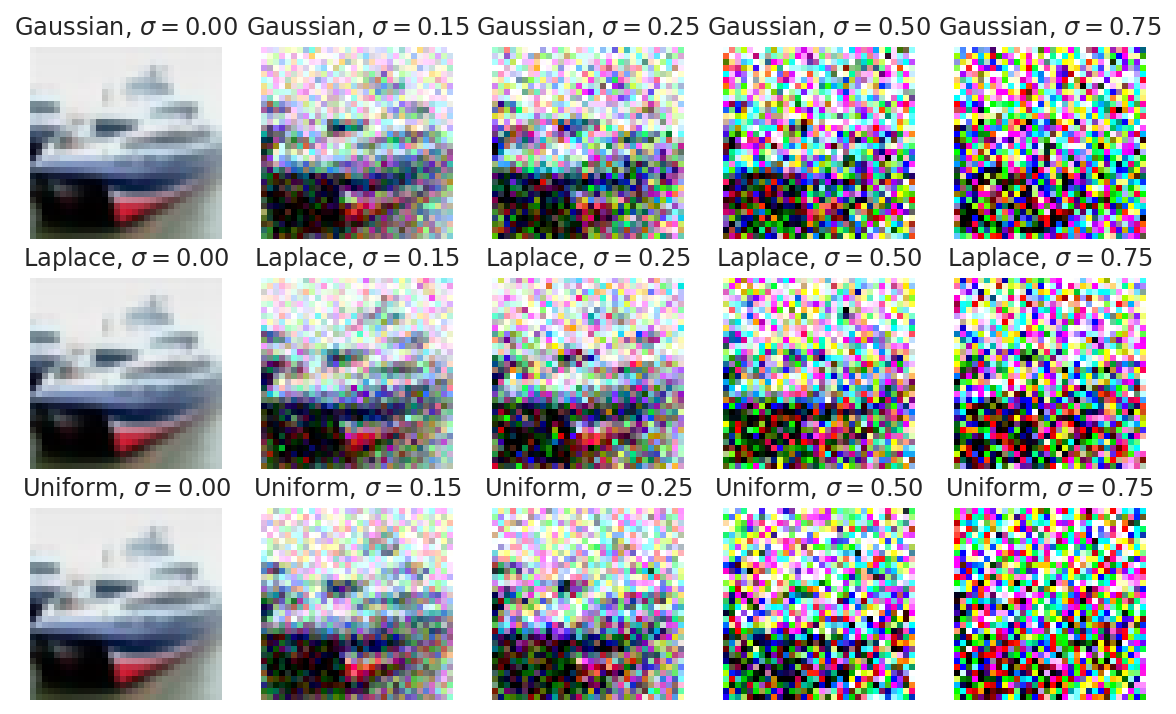

In [6]:
plt.figure(figsize=(10, 6))

for i, sigma in enumerate(sigmas):
    noise = Gaussian(sigma=sigma, dim=dim)
    sample = (noise.sample(x)).clamp(0, 1)
    plt.subplot(3, len(sigmas), i + 1)
    plot_image(sample)
    plt.axis("off")
    plt.title(f"Gaussian, $\\sigma={sigma:.2f}$")

for i, sigma in enumerate(sigmas):
    noise = Laplace(sigma=sigma, dim=dim)
    sample = (noise.sample(x)).clamp(0, 1)
    plt.subplot(3, len(sigmas), i + 1 + len(sigmas))
    plot_image(sample)
    plt.axis("off")
    plt.title(f"Laplace, $\\sigma={sigma:.2f}$")
    
for i, sigma in enumerate(sigmas):
    noise = Uniform(sigma=sigma, dim=dim)
    sample = (noise.sample(x)).clamp(0, 1)
    plt.subplot(3, len(sigmas), i + 1 + 2 * len(sigmas))
    plot_image(sample)
    plt.axis("off")
    plt.title(f"Uniform, $\\sigma={sigma:.2f}$")

To the human eye, noisy images are difficult to classify once $\sigma \geq 0.5$. 

However, it turns out neural networks can achieve high accuracy ($\approx 80\%$ on CIFAR-10 even at $\sigma=1$) on noisy images. 

(How is this possible? While the images above are clipped to the range $[0,1]$ for the purposes of visualization, the images are left unclipped when used as input to a model. So there is extra information to which the network has access.)

# Noise Certification

We now turn our focus to the certification of robust radii for a hard smoothed classifier.

Recall that, given base classifier $f$ and hard, smoothed classifier $g$, we defined, for an input $x$ at test time,

$$
\rho = \rho_{g(x)}(x) \triangleq \mathrm{Pr}_\delta\left[f(x+\delta) = g(x) \right].
$$

As mentioned above, we will actually work with an estimate $\hat \rho_\mathrm{lower}$ of $\rho$ that is a lower bound with high probability (see [Cohen et al. (2019)](https://arxiv.org/abs/1902.02918) for more details).
This value of $\hat\rho$ is what determines the $\ell_p$ radius that the smoothed classifier $g$ is robust to. 

In our code, the `noise.certify(prob_lb, adv)` function calculates the robust radius for a particular $\ell_p$ threat model and given the value of $\hat\rho$. 

For an illustration, we consider noises instantiatied with $\sigma=1.0$, and the $\ell_1$ threat model.

(0, 3)

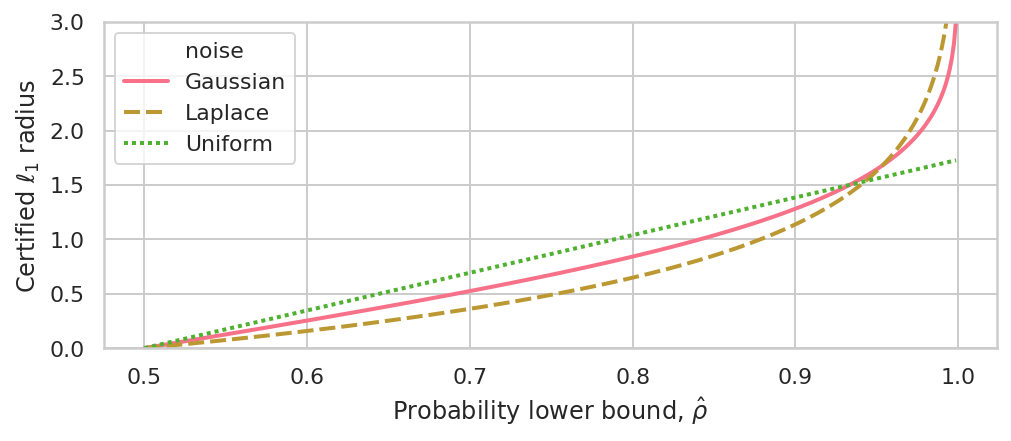

In [7]:
axis = np.linspace(0.5, 1.0, 400, endpoint=False)

df = defaultdict(list)

for noise_str in ["Gaussian", "Laplace", "Uniform"]:

    noise = eval(noise_str)(sigma=1.0, dim=dim)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise_str] * len(axis)

df = pd.DataFrame(df)
plt.figure(figsize=(8, 3))
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df)
plt.xlabel("Probability lower bound, $\\hat\\rho$")
plt.ylabel("Certified $\ell_1$ radius")
plt.ylim((0, 3))

Notice that when $\hat \rho_\mathrm{lower} \rightarrow 1$, the Laplace distribution yields the largest certified $\ell_1$ robust radius. But for smaller values of $\hat \rho_\mathrm{lower}$ the Uniform distribution yields larger radius (consistent with our theoretical analysis in the paper based on [*Wulff Crystals*](https://en.wikipedia.org/wiki/Wulff_construction)). This suggests the use of the Laplace distribution if you expect very high values of $\hat \rho_\mathrm{lower}$ and use of the Uniform distribution otherwise. 

(Empirically, we found that $\hat \rho_\mathrm{lower} \rightarrow 1$ as $\sigma \rightarrow 0$, an intuitive result. Moreover, $\hat \rho_\mathrm{lower}$ is higher on MNIST compared to CIFAR-10, perhaps since it's an "easier" dataset that admits higher clean accuracy.)



# Example: Certifying Pre-Trained Model with Uniform Noise

In this section we'll give an example of usage with Uniform noise, which we found to be the best-performing noise for $\ell_1$ certification.

We'll use the pre-trained model that we released, trained on the CIFAR-10 dataset.

In [8]:
!mkdir -p pretrain
!(! test -f "pretrain/cifar_uniform_050.pt") && wget --directory-prefix=pretrain http://www.tonyduan.com/resources/2020_rs4a_ckpts/cifar_uniform_050.pt

In [9]:
model = WideResNet(dataset="cifar", device="cuda")
saved_dict = torch.load("./pretrain/cifar_uniform_050.pt")
model.load_state_dict(saved_dict)
model.eval();

We take an image of a frog from the CIFAR-10 test set, and move it to GPU.

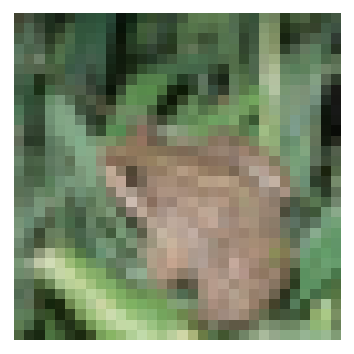

In [10]:
x, y = dataset[4]
plt.figure(figsize=(3, 3))
plot_image(x)
plt.axis("off")

x = x.unsqueeze(0).cuda()

The `smooth_predict_hard(model, x, noise, 256)` below will sample 256 noises $\delta_1, \ldots, \delta_{256}$ and add them to $x$, and return $\{model(x + \delta_i) \in \mathcal Y\}_i$, treating `model` as a hard classifier, as a histogram (i.e. normalized vote count) over $\mathcal Y$.

For example, here we find that in about 90% of noisy samples the most likely class returned by the pre-trained classifier is, indeed, a frog, while in about 10% of noisy samples the most likely class is a deer.

In [11]:
noise = Uniform(device="cuda", dim=3072, sigma=0.5)

preds = smooth_predict_hard(model, x, noise, 256)
print("Predictions:", preds.probs.cpu().numpy().round(2))

Predictions: [[0.   0.   0.   0.01 0.1  0.   0.89 0.   0.   0.  ]]


What do these noisy samples look like?

In [12]:
noisy_images = noise.sample(x.repeat((4, 1, 1, 1))).clamp(0, 1).cpu()

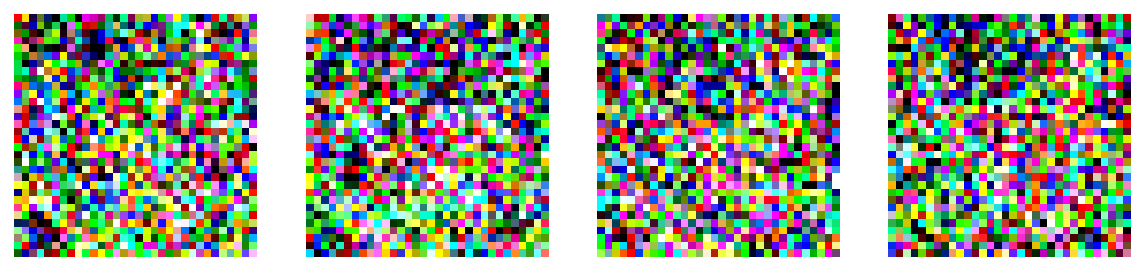

In [13]:
plt.figure(figsize=(10, 3))
for i, img in enumerate(noisy_images):
    plt.subplot(1, 4, i + 1)
    plot_image(img)
    plt.axis("off")

Using the top class that we found using 256 samples (i.e. frog), we now take 100,000 samples to compute $\hat \rho_\mathrm{lower}$ for that class.

In [14]:
top_cats = preds.probs.argmax(dim=1)
prob_lb = certify_prob_lb(model, x, top_cats, 0.001, noise, 100000)
print(f"Probability lower bound: {prob_lb:.2f}")

Probability lower bound: 0.88


Finally, we can certify the corresponding robust radius via `noise.certify`.

In [15]:
radius = noise.certify(prob_lb, adv=1)
print(f"Certified Robust L1 Radius: {radius:.2f}")

Certified Robust L1 Radius: 0.67


We can also convert this into a certified $\ell_2$ radius.
Here, specifying `adv=2` automatically does this conversion by dividing the `0.66` above by $\sqrt d = \sqrt{3 \times 32 \times 32}$.
A warning message appears to tell us that this robustness guarantee is converted from the $\ell_1$ (and $\ell_\infty$) guarantee.

In [16]:
radius = noise.certify(prob_lb, adv=2)
print(f"Certified Robust L2 Radius: {radius:.2f}")

Certified Robust L2 Radius: 0.01


/home/gregyang/myprojects/randomized-smoothing/src/noises/noises.py:95: UserWarning: No direct robustness guarantee for l2; converting l1, linf radii to l2.
  warnings.warn(f'No direct robustness guarantee for l{adv}; '


For different `noise`, `noise.certify` implements different robustness guarantee calculation made in our paper, by the *level set* method (for spherical distributions) or the *differential* method (for all other distributions). See [our paper](https://arxiv.org/abs/2002.08118) for more details.

# Appendix: $\ell_\infty$ Level Set Noises

In addition to the Uniform distribution we explore the generalized exponential $\ell_\infty$-norm and power law $\ell_\infty$-norm noises, which have cubic level sets. 

Their densities are

$$
\begin{align*}
\mathrm{ExpInf}(\lambda, k, j) && q(x) & \propto \| x/\lambda \|_\infty^{-j} e^{\|x/\lambda\|_\infty^k}\\
\mathrm{PowInf}(\lambda, j) && q(x) & \propto (1 + \|x/\lambda\|_\infty)^{-a}
\end{align*}
$$

In this section we provide examples of how to instantiate and the certification these noises.

To get better intuition, we show their densities in 2D below for $j=0,k=1,a=10$.

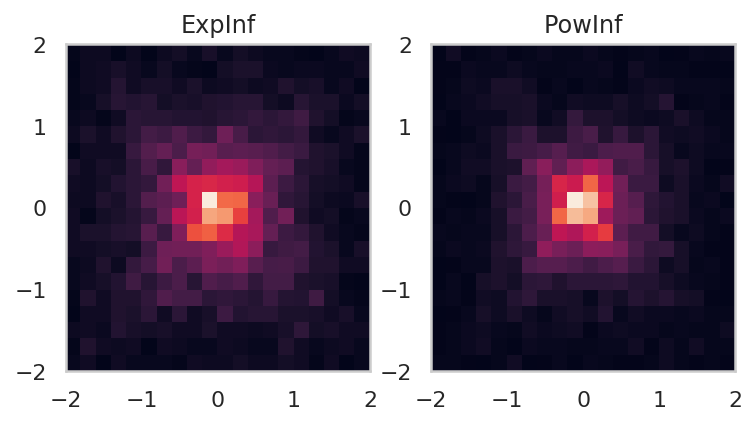

In [17]:
samples_exp = ExpInf(sigma=1.0, dim=2, k=1.0, j=0.0).sample(torch.zeros((5000, 2))).numpy()
samples_pow = PowInf(sigma=1.0, dim=2, a=10.0).sample(torch.zeros((5000, 2))).numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist2d(samples_exp[:,0], samples_exp[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("ExpInf")
plt.subplot(1, 2, 2)
plt.hist2d(samples_pow[:,0], samples_pow[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("PowInf")
plt.show()

Next we plot the certified $\ell_1$ radii vs $\hat \rho_\mathrm{lower}$ for each of these noises on a CIFAR-sized dataset (i.e. $d = 3 \times 32 \times 32$), where $\sigma=1.0$.

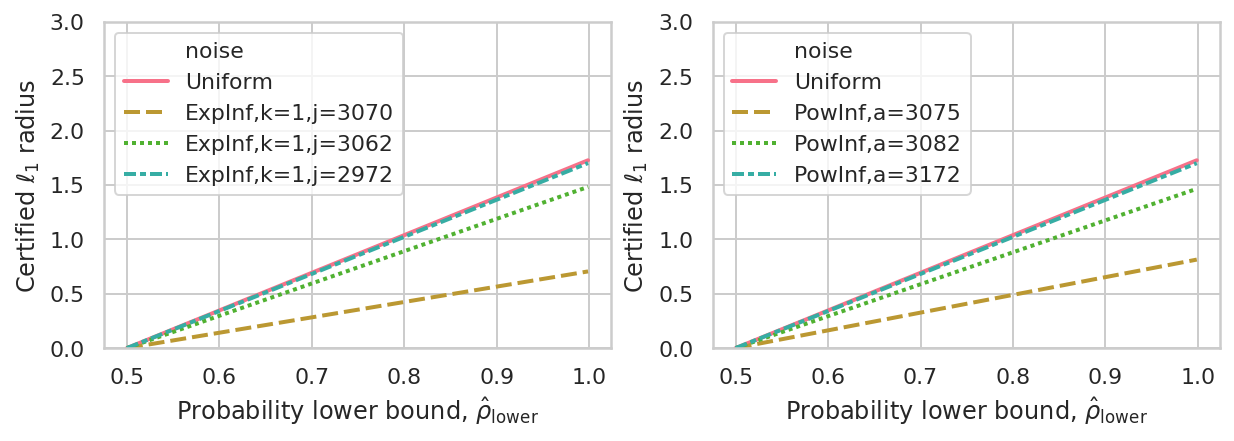

In [18]:
df = defaultdict(list)

noise = Uniform(sigma=1.0, dim=dim)
radii = noise.certify(torch.tensor(axis), adv=1).numpy()
df["radius"] += radii.tolist() * 2
df["axis"] += axis.tolist() * 2
df["noise"] += ["Uniform"] * len(axis) * 2 
df["set"] += ["pow"] * len(axis) 
df["set"] += ["exp"] * len(axis) 

for j in (dim - 2, dim - 10, dim - 100):
    
    noise = ExpInf(sigma=1.0, dim=3072, k=1, j=j)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["exp"] * len(axis)
    
for a in (dim + 3, dim + 10, dim + 100):

    noise = PowInf(sigma=1.0, dim=dim, a=a)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["pow"] * len(axis)

df = pd.DataFrame(df)
plt.figure(figsize=(10, 3))
for i, key in enumerate(("exp", "pow")):
    plt.subplot(1, 2, i + 1)
    sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df[df["set"] == key])
    plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
    plt.ylabel("Certified $\ell_1$ radius")
    plt.ylim((0, 3))

# Appendix: $\ell_2$ Level Set Noises

In addition to the Gaussian distribution we explore the generalized exponential $\ell_2$-norm and power law $\ell_2$-norm noises, which have spherical level sets. 

Their densities are

$$
\begin{align*}
\mathrm{Exp2}(\lambda, k, j) && q(x) & \propto \| x/\lambda \|_2^{-j} e^{\|x/\lambda\|_2^k}\\
\mathrm{Pow2}(\lambda, k, j) && q(x) & \propto (1 + \|x/\lambda\|_2^k)^{-a}
\end{align*}
$$

In this section we provide examples of how to instantiate and the certification these noises.

To get better intuition, we show their densities in 2D below for $j=0,k=1,a=10$.

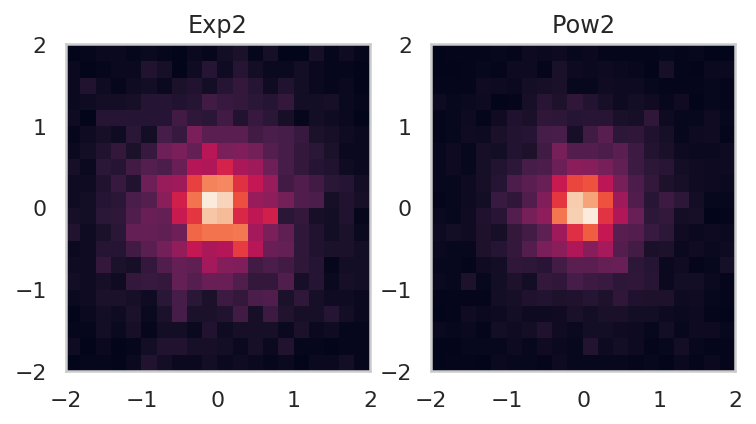

In [19]:
samples_exp = Exp2(sigma=1.0, dim=2, k=1.0, j=0.0).sample(torch.zeros((5000, 2))).numpy()
samples_pow = Pow2(sigma=1.0, dim=2, k=1.0, a=10.0).sample(torch.zeros((5000, 2))).numpy()

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist2d(samples_exp[:,0], samples_exp[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Exp2")
plt.subplot(1, 2, 2)
plt.hist2d(samples_pow[:,0], samples_pow[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Pow2")
plt.show()

Next we plot the certified $\ell_2$ radius vs $\hat \rho_\mathrm{lower}$ for each of these noises on a CIFAR-sized dataset (i.e. $d = 3 \times 32 \times 32$), where $\sigma=1.0$.

Found and loaded saved table: exp2_l2_d3072_k2_j500_inc0.01_gridradius_upper3
Found and loaded saved table: exp2_l2_d3072_k2_j3071_inc0.01_gridradius_upper3
Found and loaded saved table: exp2_l2_d3072_k2_j3068_inc0.01_gridradius_upper3
Found and loaded saved table: exp2_l2_d3072_k2_j3064_inc0.01_gridradius_upper3
Found and loaded saved table: pow2_l2_d3072_k2_a1538_inc0.01_gridradius_upper3
Found and loaded saved table: pow2_l2_d3072_k2_a1540_inc0.01_gridradius_upper3
Found and loaded saved table: pow2_l2_d3072_k2_a1544_inc0.01_gridradius_upper3


(0, 3)

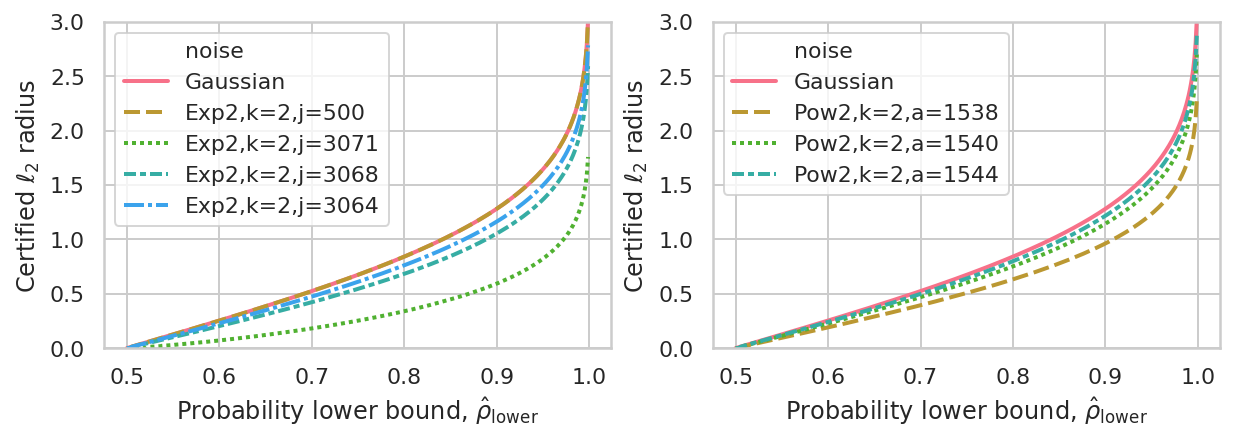

In [20]:
df = defaultdict(list)

noise = Gaussian(sigma=1.0, dim=dim)
radii = noise.certify(torch.tensor(axis), adv=2).numpy()
df["radius"] += radii.tolist() * 2
df["axis"] += axis.tolist() * 2
df["noise"] += ["Gaussian"] * len(axis) * 2 
df["set"] += ["pow"] * len(axis) 
df["set"] += ["exp"] * len(axis) 

for j in (500, dim - 1, dim - 4, dim - 8):

    noise = Exp2(sigma=1.0, dim=3072, k=2, j=j)
    radii = noise.certify(torch.tensor(axis), adv=2).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["exp"] * len(axis)
    
for a in (0.5 * dim + 2, 0.5 * dim + 4, 0.5 * dim + 8):

    noise = Pow2(sigma=1.0, dim=dim, a=int(a), k=2)
    radii = noise.certify(torch.tensor(axis), adv=2).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    df["set"] += ["pow"] * len(axis)

df = pd.DataFrame(df)
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df[df["set"] == "exp"])
plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
plt.ylabel("Certified $\ell_2$ radius")
plt.ylim((0, 3))
plt.subplot(1, 2, 2)
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df[df["set"] == "pow"])
plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
plt.ylabel("Certified $\ell_2$ radius")
plt.ylim((0, 3))

# Appendix: $\ell_1$ Level Set Noises

In addition to the Laplace distribution we explore the generalized exponential $\ell_1$-norm noise, which has $\ell_1$-ball shaped level sets.

Its density is

$$
\begin{align*}
\mathrm{Exp1}(\lambda, k) && q(x) & \propto  e^{\|x/\lambda\|_1^k}
\end{align*}
$$

In this section we provide examples of how to instantiate and the certification this noises.

To get better intuition, we show their densities in 2D below for $k=2$.

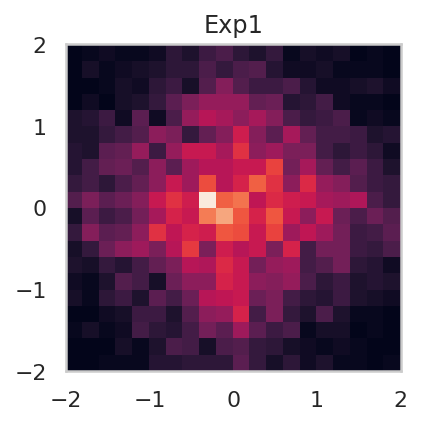

In [21]:
samples_exp = Exp1(sigma=1.0, dim=2, k=2).sample(torch.zeros((5000, 2))).numpy()

plt.figure(figsize=(3, 3))
plt.hist2d(samples_exp[:,0], samples_exp[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Exp1")
plt.show()

Next we plot the certified $\ell_1$ radius vs $\hat \rho_\mathrm{lower}$ for each of these noises on a CIFAR-sized dataset (i.e. $d = 3 \times 32 \times 32$), where $\sigma=1.0$.

Found and loaded saved table: exp1_l1_d3072_k10_inc0.001_gridradius_upper3
Found and loaded saved table: exp1_l1_d3072_k100_inc0.001_gridradius_upper3
Found and loaded saved table: exp1_l1_d3072_k200_inc0.001_gridradius_upper3


Text(0, 0.5, 'Certified $\\ell_1$ radius')

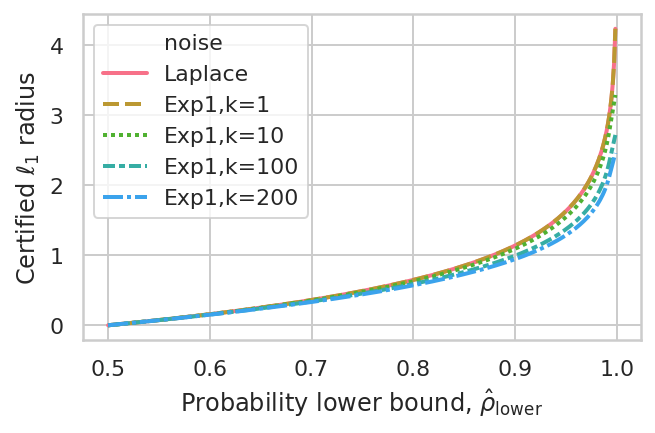

In [22]:
df = defaultdict(list)

noise = Laplace(sigma=1.0, dim=dim)
radii = noise.certify(torch.tensor(axis), adv=1).numpy()
df["radius"] += radii.tolist()
df["axis"] += axis.tolist()
df["noise"] += ["Laplace"] * len(axis)

for k in (1, 10, 100, 200):

    noise = Exp1(sigma=1.0, dim=3072, k=k)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    
df = pd.DataFrame(df)
plt.figure(figsize=(5, 3))
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df)
plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
plt.ylabel("Certified $\ell_1$ radius")

# Appendix: $\ell_p$ Level Set Noises

Let's consider distributions of the form

$$
\begin{align*}
\mathrm{Exp}p(\lambda, k=p) && q(x) & \propto  e^{\|x/\lambda\|_p^p}
\end{align*}
$$

What happens when we let $p$ vary continuously between 0 and $\infty$?

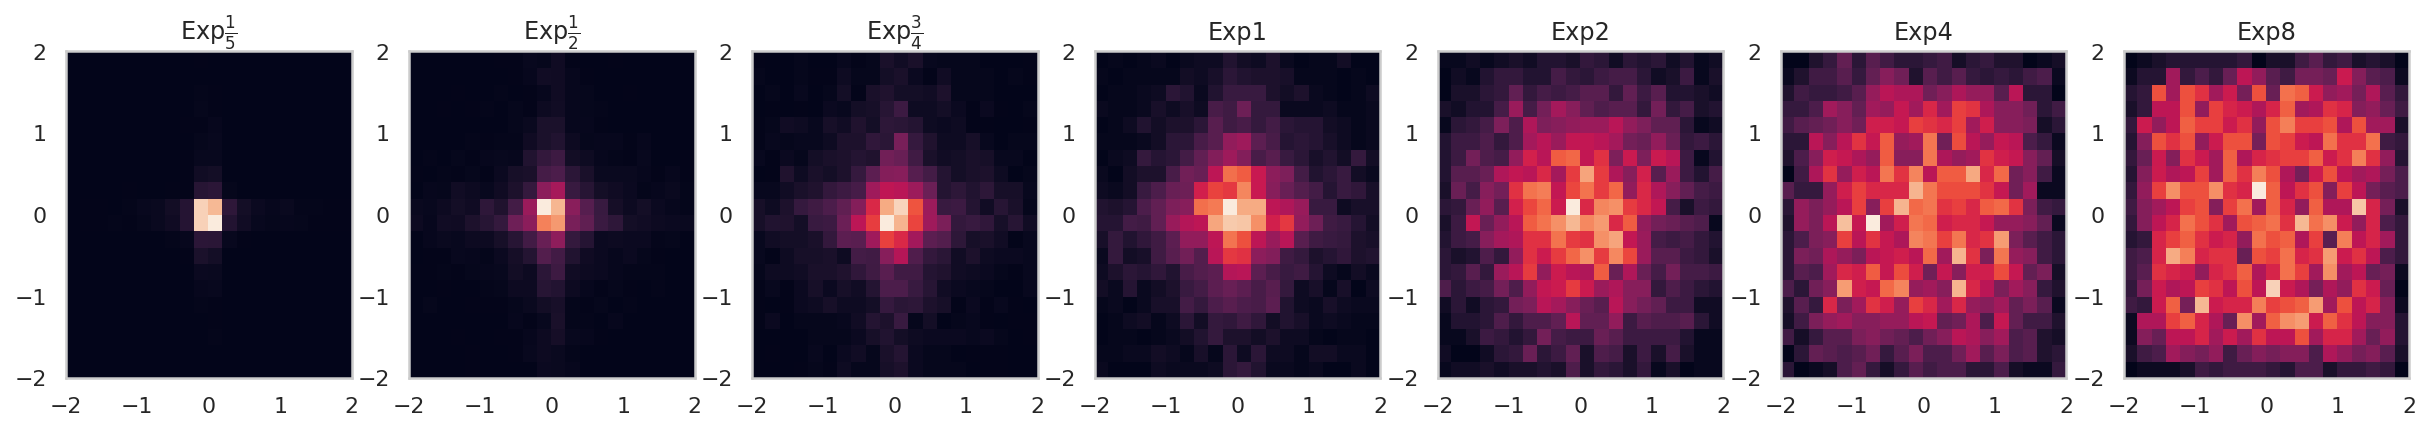

In [23]:
samples_exp_fifth = Expp(sigma=1.0, dim=2, p=0.2).sample(torch.zeros((5000, 2))).numpy()
samples_exp_half = Expp(sigma=1.0, dim=2, p=0.5).sample(torch.zeros((5000, 2))).numpy()
samples_exp_3_4th = Expp(sigma=1.0, dim=2, p=3/4).sample(torch.zeros((5000, 2))).numpy()
samples_exp1 = Expp(sigma=1.0, dim=2, p=1).sample(torch.zeros((5000, 2))).numpy()
samples_exp2 = Expp(sigma=1.0, dim=2, p=2).sample(torch.zeros((5000, 2))).numpy()
samples_exp4 = Expp(sigma=1.0, dim=2, p=4).sample(torch.zeros((5000, 2))).numpy()
samples_exp8 = Expp(sigma=1.0, dim=2, p=8).sample(torch.zeros((5000, 2))).numpy()

plt.figure(figsize=(21, 3))
plt.subplot(1, 7, 1)
plt.hist2d(samples_exp_fifth[:,0], samples_exp_fifth[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp$\frac{1}{5}$")
plt.subplot(1, 7, 2)
plt.hist2d(samples_exp_half[:,0], samples_exp_half[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp$\frac{1}{2}$")
plt.subplot(1, 7, 3)
plt.hist2d(samples_exp_3_4th[:,0], samples_exp_3_4th[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp$\frac{3}{4}$")
plt.subplot(1, 7, 4)
plt.hist2d(samples_exp1[:,0], samples_exp1[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp1")
plt.subplot(1, 7, 5)
plt.hist2d(samples_exp2[:,0], samples_exp2[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp2")
plt.subplot(1, 7, 6)
plt.hist2d(samples_exp4[:,0], samples_exp4[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp4")
plt.subplot(1, 7, 7)
plt.hist2d(samples_exp8[:,0], samples_exp8[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title(r"Exp8")

plt.show()

As one might expect, the histograms reveal $\ell_p$ balls contours as $p$ varies freely, going from highly concave ($p < 1$) to a rhombus ($p=1$) to a sphere ($p=2$) and toward a square ($p > 2$).

Next we plot the certified $\ell_1$ radius vs $\hat \rho_\mathrm{lower}$ for each of these noises on a CIFAR-sized dataset (i.e. $d = 3 \times 32 \times 32$), where $\sigma=1.0$.
We find that $p < 1$ is much worse than $p \ge 1$.

Found and loaded saved table: exp0.2_l1_d3072_k0.2_rhomax0.999_gridsize3000


Text(0, 0.5, 'Certified $\\ell_1$ radius')

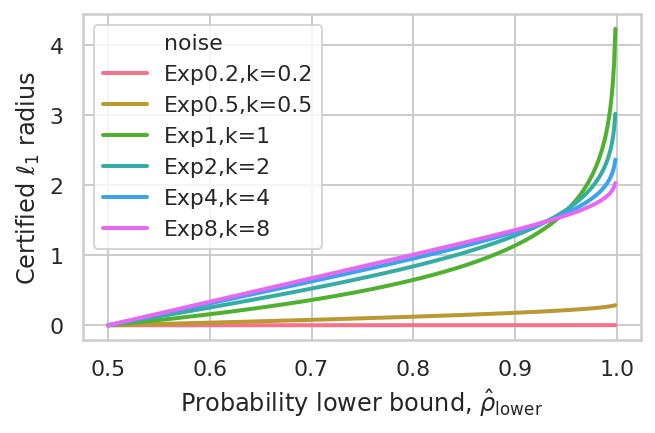

In [24]:
df = defaultdict(list)

for p in (0.2, 0.5, 1, 2, 4, 8):

    noise = Expp(sigma=1.0, dim=3072, p=p)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    
df = pd.DataFrame(df)
plt.figure(figsize=(5, 3))
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df, dashes=False)
plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
plt.ylabel("Certified $\ell_1$ radius")

# Appendix: Pareto Noise

All of the noises above have level sets that are of the same shape.
Here we explore Pareto noise, which has varying level sets, going from near convex (corresponding to high levels) to very concave (corresponding to low levels).
It has density

$$
\begin{align*}
\mathrm{Pareto}(\lambda, a) && q(x) & \propto  \prod_{i=1}^d \frac a {2\lambda} \left( 1 + \left| \frac{x_i}{\lambda} \right|\right)^{-1-a}
\end{align*}
$$

and is the stereotypical "polynomial tail" distribution.
By varying $a$, we can emphasize different level sets of the Pareto distribution.

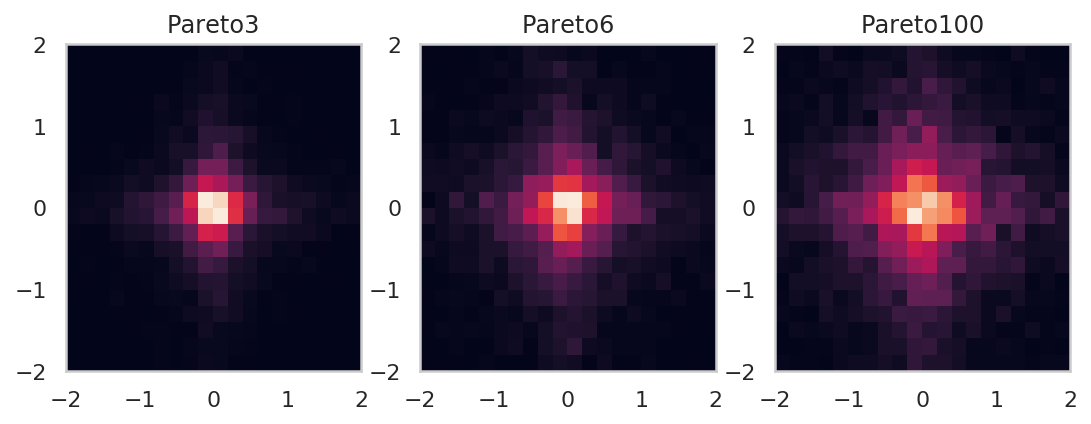

In [25]:
samples_pareto3 = Pareto(sigma=1.0, dim=2, a=3).sample(torch.zeros((6000, 2))).numpy()
samples_pareto6 = Pareto(sigma=1.0, dim=2, a=6).sample(torch.zeros((6000, 2))).numpy()
samples_pareto100 = Pareto(sigma=1.0, dim=2, a=100).sample(torch.zeros((6000, 2))).numpy()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.hist2d(samples_pareto3[:,0], samples_pareto3[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Pareto3")
plt.subplot(1, 3, 2)
plt.hist2d(samples_pareto6[:,0], samples_pareto6[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Pareto6")
plt.subplot(1, 3, 3)
plt.hist2d(samples_pareto100[:,0], samples_pareto100[:,1], range=((-2, 2), (-2, 2)), density=True, bins=20)
plt.title("Pareto100")
plt.show()

In general, it seems that larger $a$ yields better robust radii, converging to the robust radii of the Laplace distribution.
While this may seem puzzling at first, one can note that, as shown in the histograms above, large-$a$ Pareto distribution concentrates on a cross polytope in high dimension, which is close to Laplace in a suitable sense.

Text(0, 0.5, 'Certified $\\ell_1$ radius')

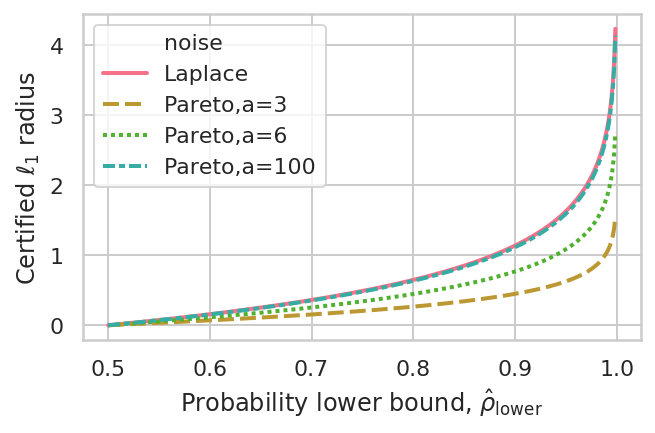

In [26]:
df = defaultdict(list)

noise = Laplace(sigma=1.0, dim=dim)
radii = noise.certify(torch.tensor(axis), adv=1).numpy()
df["radius"] += radii.tolist()
df["axis"] += axis.tolist()
df["noise"] += ["Laplace"] * len(axis)

for a in (3, 6, 100):

    noise = Pareto(sigma=1.0, dim=3072, a=a)
    radii = noise.certify(torch.tensor(axis), adv=1).numpy()
    df["radius"] += radii.tolist()
    df["axis"] += axis.tolist()
    df["noise"] += [noise.plotstr()] * len(axis)
    
df = pd.DataFrame(df)
plt.figure(figsize=(5, 3))
sns.lineplot(x="axis", y="radius", hue="noise", style="noise", data=df)
plt.xlabel("Probability lower bound, $\\hat\\rho_\\mathrm{lower}$")
plt.ylabel("Certified $\ell_1$ radius")